In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import re
import pandas as pd
import talib

np.set_printoptions(suppress=True)

import sys, os
sys.path.append("../src")

from helpers import build_distance_matrix
from macro_models import batched_gaussian_process
from priors import diffusion_prior, length_scale_prior, diffusion_prior_gp
from micro_models import dynamic_batch_diffusion, fast_dm_simulate, diffusion_trial
from networks_10092022 import DynamicGaussianNetworkJoint
from context import generate_design_matrix
from transformations import unscale_z

In [ ]:
import tensorflow_probability as tfp
tfd = tfp.distributions
tfpl = tfp.layers

In [ ]:
from tensorflow.keras.layers import GRU, Dense, LSTM
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.utils import to_categorical

In [ ]:
from tqdm.notebook import tqdm
from functools import partial

In [5]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
print(tf.config.list_physical_devices('GPU'))


# physical_devices = tf.config.list_physical_devices('CPU')
# tf.config.set_visible_devices([], 'GPU')
# os.environ["CUDA_VISIBLE_DEVICES"]="-1" 

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2022-10-28 18:01:07.846472: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-28 18:01:07.876121: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-28 18:01:07.876285: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


# Constants

In [6]:
T = 3200
DIST_MAT = build_distance_matrix(T)
# AMPLITUDES = [0.20, 0.20, 0.20, 0.20, 0.20, 0.15]
AMPLITUDES = [0.15, 0.15, 0.15, 0.15, 0.1, 0.05]
BATCH_SIZE = 16
TEST_SIZE = 10
N_CHUNKS = 4000
EPOCHS = 100

2022-10-28 18:01:07.883391: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-28 18:01:07.883908: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-28 18:01:07.884080: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-28 18:01:07.884201: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [7]:
# PARAMS_MEAN = [10.0, 10.0, 10.0, 10.0, 10.0, 10.0,
#                1.6, 1.6, 1.6, 1.6, 1.6, 0.5,]
# PARAMS_STD = [5.7, 5.7, 5.7, 5.7, 5.7 , 5.7,
#               1.75, 1.75, 1.75, 1.75, 1.75, 0.6]

In [8]:
PARAMS_MEAN = [5.0, 5.0, 5.0, 5.0, 5.0, 5.0,
               1.2, 1.2, 1.2, 1.2, 1.2, 0.3]
PARAMS_STD = [2.75, 2.75, 2.75, 2.75, 2.75 , 2.75,
              1.0, 1.0, 1.0, 1.0, 1.0, 0.25]

In [9]:
EMPIRIC_COLOR = '#1F1F1F'
NEURAL_COLOR = '#852626'
COMPARISON_COLOR = '#133a76'

## Network

In [10]:
def generator_fun(batch_size):
    theta0 = diffusion_prior(batch_size, n_cond=4)
    eta = length_scale_prior(batch_size, 6)
    eta_t = np.stack([eta] * T, axis=1)
    theta_t = batched_gaussian_process(theta0, DIST_MAT, eta, amplitudes=AMPLITUDES)
    context = generate_design_matrix(batch_size, T)
    rt = dynamic_batch_diffusion(theta_t, context)
    x = np.concatenate((rt, to_categorical(context[:, :, np.newaxis])), axis=-1)

    params_t = np.concatenate([eta_t, theta_t], axis=-1)
    params_t_z = (params_t - PARAMS_MEAN) / PARAMS_STD
    
    return params_t_z.astype(np.float32), x.astype(np.float32)

In [11]:
params_t_z, x = generator_fun(32)

In [12]:
# f, axarr = plt.subplots(10, 6, figsize=(25, 30))
# time = np.arange(1, theta.shape[1]+1)
# for j in range(10):
#     for i in range(6):
#         ax = axarr[j, i]
#         ax.plot(time, theta[j, :, i], label='True', color='black', linestyle='dashed')
#         sns.despine(ax=ax)
#         ax.legend()
#         ax.grid(alpha=0.3)
# f.tight_layout()

In [13]:
def presimulate_data():
    for n in range(N_CHUNKS):
        params_t_z, x = generator_fun(BATCH_SIZE)
        np.save(f'../data/offline_data/data/x_{n}.npy', x)
        np.save(f'../data/offline_data/parameters/parameters_{n}.npy', params_t_z)

In [14]:
# presimulate_data()

In [15]:
class ChunkLoader:
    def __init__(self, path_to_data):
        self.path_to_data = path_to_data
        self.data_list = sorted(os.listdir(os.path.join(path_to_data, 'data')), key=lambda f: int(re.sub('\D', '', f)))
        self.params_list = sorted(os.listdir(os.path.join(path_to_data, 'parameters')), key=lambda f: int(re.sub('\D', '', f)))
        self.indices = list(range(len(self.data_list)))
        np.random.shuffle(self.indices)
        self.num_batches = len(self.data_list)
        self.current_index = 0
        
    def __iter__(self):
        return self
    
    def __next__(self):
        if self.current_index < self.num_batches:
            self.current_index += 1
            idx = self.indices[self.current_index -1]
            batch_x = np.load(os.path.join(self.path_to_data, 'data', self.data_list[idx]))
            batch_params = np.load(os.path.join(self.path_to_data, 'parameters', self.params_list[idx]))
            return batch_params, batch_x
        self.indices = list(range(len(self.data_list)))
        np.random.shuffle(self.indices)
        self.current_index = 0
        raise StopIteration

In [16]:
loader = ChunkLoader('../data/offline_data')

In [17]:
network_settings = {
    'embedding_lstm_units' : 512, 
    'embedding_gru_units': 512,
    'embedding_dense_args': dict(units=256, activation='selu', kernel_initializer='lecun_normal'),
    'posterior_dense_args': dict(units=128, activation='selu', kernel_initializer='lecun_normal'),
    'n_micro_params': 6,
    'n_macro_params': 6
}
network = DynamicGaussianNetworkJoint(network_settings)

In [18]:
steps_per_epoch = 500
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=2500,
    decay_rate=0.8,
    staircase=True
)
optimizer = tf.keras.optimizers.Adam(lr_schedule)

In [19]:
def nll(y_true, y_pred):
    return tf.reduce_mean(-y_pred.log_prob(y_true))

In [20]:
def epoch_trainer(generator, network, optimizer, steps_per_epoch, p_bar):
    losses = []
    for step, batch in enumerate(generator):
        with tf.GradientTape() as tape:
            
            # Simulate from model
            params_t_z, data = batch
            
            idx = np.random.choice(np.arange(0, 16), size=8, replace=False, p=None)

            # Forward pass
            posterior = network(data[idx])

            # loss computation
            loss = nll(params_t_z[idx], posterior)
        
        # One step backprop
        g = tape.gradient(loss, network.trainable_variables)
        optimizer.apply_gradients(zip(g, network.trainable_variables))
        losses.append(loss.numpy())

        # Update progress bar
        p_bar.set_postfix_str("Ep: {},Step {},Loss: {:.3f},Loss.Avg: {:.3f}"
                              .format(ep, step, loss.numpy(), np.mean(losses)))
        p_bar.update(1)
    return losses

In [21]:
losses = []
for ep in range(1, EPOCHS+1):
    with tqdm(total=loader.num_batches, desc=f'Training Epoch {ep}') as p_bar:
        loss_ep = epoch_trainer(loader, network, optimizer, steps_per_epoch, p_bar)
        losses.append(loss_ep)
    network.save_weights('../trained_networks/gp_ddm_3200_joint_offline_new')

Training Epoch 1:   0%|          | 0/4000 [00:00<?, ?it/s]

2022-10-28 18:01:32.184223: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


Training Epoch 2:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 3:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 4:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 5:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 6:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 7:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 8:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 9:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 10:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 11:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 12:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 13:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 14:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 15:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 16:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 17:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 18:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 19:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 20:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 21:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 22:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 23:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 24:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 25:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 26:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 27:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 28:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 29:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 30:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 31:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 32:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 33:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 34:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 35:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 36:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 37:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 38:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 39:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 40:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 41:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 42:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 43:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 44:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 45:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 46:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 47:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 48:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 49:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 50:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 51:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 52:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 53:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 54:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 55:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 56:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 57:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 58:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 59:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 60:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 61:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 62:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 63:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 64:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 65:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 66:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 67:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 68:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 69:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 70:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 71:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 72:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 73:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 74:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 75:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 76:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 77:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 78:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 79:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 80:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 81:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 82:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 83:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 84:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 85:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 86:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 87:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 88:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 89:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 90:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 91:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 92:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 93:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 94:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 95:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 96:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 97:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 98:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 99:   0%|          | 0/4000 [00:00<?, ?it/s]

Training Epoch 100:   0%|          | 0/4000 [00:00<?, ?it/s]

# Validation

In [ ]:
network.load_weights('../trained_networks/gp_ddm_3200_joint_offline')

## Gen Test Data

In [22]:
params_test, x_test = generator_fun(TEST_SIZE)

## Predict

In [23]:
preds = network(x_test)

In [24]:
theta_means = preds.mean()[:, :, 6:]  * PARAMS_STD[6:] + PARAMS_MEAN[6:]
theta_stds = preds.stddev()[:, :, 6:] * PARAMS_STD[6:]
theta_test = params_test[:, :, 6:] * PARAMS_STD[6:] + PARAMS_MEAN[6:]

##  Visualize Predictions Over Time

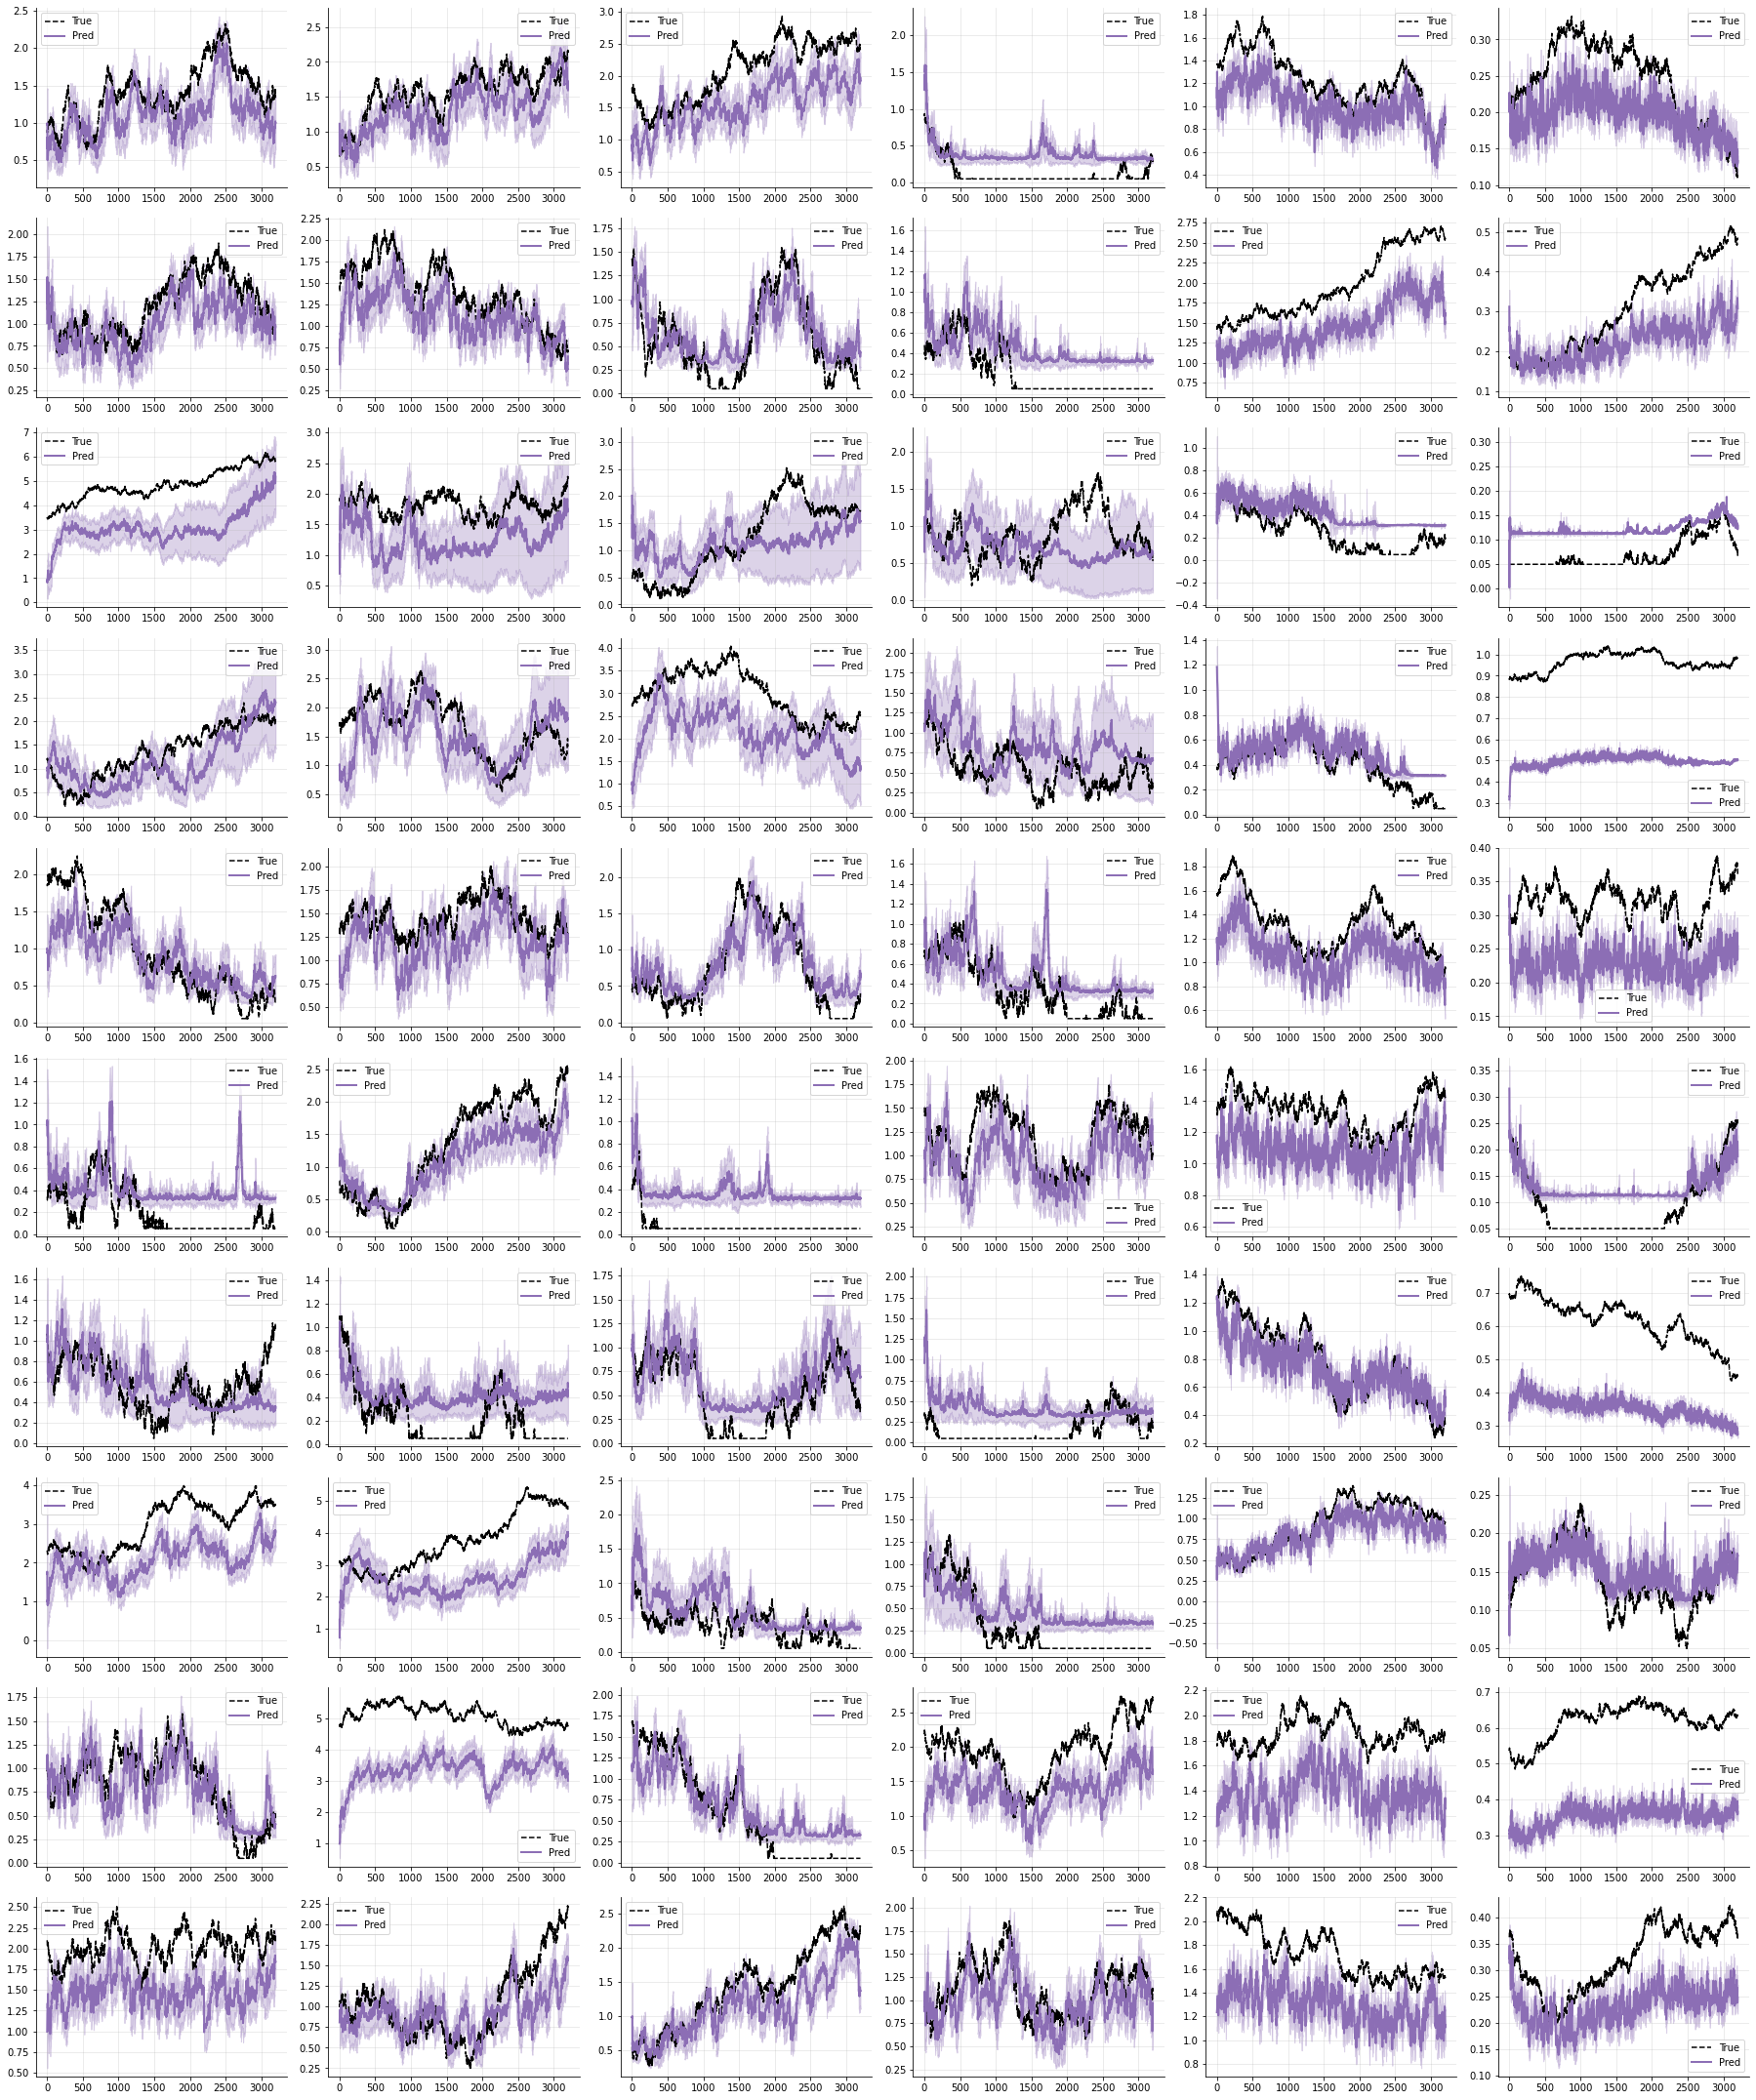

In [25]:
f, axarr = plt.subplots(TEST_SIZE, 6, figsize=(25, 30))
std_mul = 1
time = np.arange(1, theta_test.shape[1]+1)
for j in range(TEST_SIZE):
    for i in range(6):
        ax = axarr[j, i]
        ax.plot(time, theta_test[j, :, i], label='True', color='black', linestyle='dashed')
        ax.plot(time, theta_means[j, :, i], label='Pred', lw=2, color='#8c6eb5')
        ax.fill_between(time, 
                        theta_means[j, :, i] + std_mul * theta_stds[j, :, i], 
                        theta_means[j, :, i] - std_mul * theta_stds[j, :, i], color='#8c6eb5', alpha=0.3)
        sns.despine(ax=ax)
        ax.legend()
        ax.grid(alpha=0.3)
f.tight_layout()

In [ ]:
post_samples = preds.sample(100)
f, axarr = plt.subplots(TEST_SIZE, 6, figsize=(25, 30))
std_mul = 2
time = np.arange(1, theta_test.shape[1]+1)
for j in range(TEST_SIZE):
    for i in range(6):
        ax = axarr[j, i]
        sns.kdeplot(post_samples[:, j, -1, i], ax=ax, fill='maroon')
        ax.axvline(params_test[j, -1, i], color='red')

## Visualize Slices

In [ ]:
# VAL_SIZE = 300
# theta0 = diffusion_prior_gp(VAL_SIZE, n_cond=1)
# eta = length_scale_prior(VAL_SIZE, 3)
# theta_test = batched_gaussian_process(theta0, DIST_MAT, eta, amplitudes=AMPLITUDES)
# rt_test = simple_batch_diffusion(theta_test).astype(np.float32)
# SLICE_POINTS = [2, 50, 100]

In [ ]:
# theta_preds = network(rt_test)
# theta_means = theta_preds.mean().numpy() * PARAMS_STD + PARAMS_MEAN
# theta_stds = theta_preds.stddev().numpy() * PARAMS_STD

In [ ]:
# f, axarr = plt.subplots(len(SLICE_POINTS), 3, figsize=(10, 10))
# for j in range(len(SLICE_POINTS)):
#     for i in range(3):
#         ax = axarr[j, i]
#         true = theta_test[:, SLICE_POINTS[j]-1, i]
#         pred = theta_means[:, SLICE_POINTS[j]-1, i]
#         std = theta_stds[:, SLICE_POINTS[j]-1, i]
#         ax.errorbar(true, pred, yerr=std, fmt='o', alpha=0.5, color='#8c6eb5')
#         # ax.scatter(true, pred, color='#8c6eb5')
#         sns.despine(ax=ax)
#         ax.grid(alpha=0.3)
        
#         lower = min(true.min(), pred.min())
#         upper = max(true.max(), pred.max())
#         eps = (upper - lower) * 0.1
#         ax.set_xlim([lower - eps, upper + eps])
#         ax.set_ylim([lower - eps, upper + eps]) 
#         ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [ax.get_ylim()[0], ax.get_ylim()[1]], 
#                  color='black', alpha=0.9, linestyle='dashed')
#         ax.set_xlabel('True')
#         ax.set_ylabel('Estimated mean')
#         if i == 0:
#             ax.text(-0.5, 0.5, f'T={SLICE_POINTS[j]}',
#             horizontalalignment='left',
#             verticalalignment='center',
#             transform=ax.transAxes)
# f.tight_layout()

## Empirical data

In [ ]:
N_OBS      = 3200
BATCH_SIZE = 8
N_SAMPLES  = 2000
N_PARAMS   = 6
N_SIM      = 100
N_SUBS     = 11
HORIZON    = 800

PARAM_LABELS = ['Drift rate 1', 'Drift rate 2', 'Drift rate 3', 'Drift rate 4', 'Threshold', 'Non-decision time']
PARAM_NAMES  = [r'$v_1$', r'$v_2$', r'$v_3$', r'$v_4$', r'$a$', r'$\tau$']

In [ ]:
# read data
data = pd.read_csv('../data/data_lexical_decision.csv', sep=',', header=0)

# prepare data for fitting
ids = np.unique(data.id)
N_SUBS = len(ids)

# negative rts for error responses
data.rt.loc[data.acc == 0] = -data.rt.loc[data.acc == 0]

# iterate over subjects
x_nn = np.zeros((len(ids), N_OBS, 5))

for id in ids:
    person_data = data[data.id == id]
    rt = np.array([person_data.rt])[:, :, np.newaxis]
    stim_type = np.array([person_data.stim_type])[:, :, np.newaxis] - 1 
    context = to_categorical(stim_type)
    x_nn[id-1] = tf.concat((rt, context), axis=-1)

x_nn.shape

In [ ]:
# inference
posterior_z = network(x_nn)
post_samples = posterior_z.sample(100)
post_theta_t = unscale_z(post_samples[:, :, :, 6:], PARAMS_MEAN[6:], PARAMS_STD[6:]).numpy().astype(np.float32)
post_eta = unscale_z(post_samples[:, :, :, :6], PARAMS_MEAN[:6], PARAMS_STD[:6]).numpy().astype(np.float32)
post_theta_t.shape

In [ ]:
# read fast-dm parameter estimates
fast_dm_params = pd.read_csv('../data/parameters_full_ddm_error_coding_cs.lst', encoding='iso-8859-1', header=0, delim_whitespace=True)
fast_dm_params['dataset'] = fast_dm_params['dataset'].str.extract('(\d+)').astype(int)
fast_dm_params = fast_dm_params[['dataset', 'v_1', 'v_2', 'v_3', 'v_4', 'a', 't0', 'sv', 'st0']]
fast_dm_params = fast_dm_params.sort_values('dataset')
fast_dm_params = fast_dm_params.reset_index(drop=True)
fast_dm_params = fast_dm_params.to_numpy()[:, 1:]
fast_dm_params.shape

In [ ]:
# predict data with fast_dm for all subjects
pred_rt_fast_dm = np.zeros((N_SUBS, N_OBS))
for i in range(N_SUBS):
    context = data.stim_type.loc[data.id == i+1].to_numpy() - 1
    pred_rt_fast_dm[i] = fast_dm_simulate(fast_dm_params[i], context)
    
pred_rt_fast_dm.shape

In [ ]:
def pr_check(emp_data, post_theta_t, n_sim, sma_period=5):
    # get experimental context
    context = emp_data.stim_type.values - 1
    # get empirical response times
    emp_rt = np.abs(emp_data.rt.values)
    sma_emp_rt = talib.SMA(emp_rt, timeperiod=sma_period)
    

    n_obs = emp_rt.shape[0]
    pred_rt = np.zeros((n_sim, n_obs))
    sma_pred_rt = np.zeros((n_sim, n_obs))
    # iterate over number of simulations
    for sim in range(n_sim):
        # Iterate over number of trials
        rt = np.zeros(n_obs)
        for t in range(n_obs):
            # Run diffusion process
            rt[t] = diffusion_trial(post_theta_t[sim, t, context[t]], post_theta_t[sim, t, 4], post_theta_t[sim, t, 5])
        pred_rt[sim] = np.abs(rt)
        sma_pred_rt[sim] = talib.SMA(np.abs(rt), timeperiod=sma_period)

    return pred_rt, sma_pred_rt, emp_rt, sma_emp_rt

In [ ]:
# predict data with neural for all subjects
pred_rt_neural = np.zeros((N_SUBS, N_SIM, N_OBS))
sma_pred_rt_neural = np.zeros((N_SUBS, N_SIM, N_OBS))

pred_rt_quantiles = np.zeros((N_SUBS, 2, N_OBS))
pred_rt_medians = np.zeros((N_SUBS, N_OBS))

emp_rt =  np.zeros((N_SUBS, N_OBS))
sma_emp_rt =  np.zeros((N_SUBS, N_OBS))

for sub in range(N_SUBS):
    # predict RTs
    person_data = data[data.id == sub+1]
    pred_rt_neural[sub], sma_pred_rt_neural[sub], emp_rt[sub], sma_emp_rt[sub] = pr_check(person_data, post_theta_t[:, sub, :, :], N_SIM)
    # compute RT quantiles
    pred_rt_quantiles[sub] = np.quantile(sma_pred_rt_neural[sub], [0.025, 0.975], axis=0)
    pred_rt_medians[sub] = np.median(sma_pred_rt_neural[sub], axis=0)
    print("Sub nr. {} is predicted".format(sub+1))

In [ ]:
# inference on subsetted data set
horizon=800
emp_data_horizon = x_nn[:, :N_OBS-horizon, :]

posterior_horizon_z = network(emp_data_horizon)
post_horizon_samples = posterior_horizon_z.sample(100)
post_theta_last = unscale_z(post_horizon_samples[:, :, -1, 6:], PARAMS_MEAN[6:], PARAMS_STD[6:]).numpy().astype(np.float32)
post_eta_last = unscale_z(post_horizon_samples[:, :, -1, :6], PARAMS_MEAN[:6], PARAMS_STD[:6]).numpy().astype(np.float32)
print(post_theta_last.shape)
print(post_eta_last.shape)

In [ ]:
# np.save('../saved_arrays/emp_rt_gpddm.npy', emp_rt)
# np.save('../saved_arrays/sma_emp_rt_gpddm.npy', sma_emp_rt)
# np.save('../saved_arrays/pred_rt_fast_dm_gpddm.npy', pred_rt_fast_dm)
# np.save('../saved_arrays/pred_rt_neural_gpddm.npy', pred_rt_neural)
# np.save('../saved_arrays/pred_rt_medians_gpddm.npy', pred_rt_medians)
# np.save('../saved_arrays/pred_rt_quantiles_gpddm.npy', pred_rt_quantiles)

# np.save('../saved_arrays/post_eta_last.npy', post_eta_last)
# np.save('../saved_arrays/post_theta_last.npy', post_theta_last)
# np.save('../saved_arrays/post_eta.npy', post_eta)
# np.save('../saved_arrays/post_theta_t.npy', post_theta_t)

In [ ]:
emp_rt = np.load('../saved_arrays/emp_rt_gpddm.npy')
sma_emp_rt = np.load('../saved_arrays/sma_emp_rt_gpddm.npy')
pred_rt_fast_dm = np.load('../saved_arrays/pred_rt_fast_dm_gpddm.npy')
pred_rt_neural = np.load('../saved_arrays/pred_rt_neural_gpddm.npy')
pred_rt_medians = np.load('../saved_arrays/pred_rt_medians_gpddm.npy')
pred_rt_quantiles = np.load('../saved_arrays/pred_rt_quantiles_gpddm.npy')

post_eta_last = np.load('../saved_arrays/post_eta_last.npy')
post_theta_last = np.load('../saved_arrays/post_theta_last.npy')

In [ ]:
# generate dynamic parameters and simulate RTs
pred_rt_horizon = np.zeros((N_SIM, N_SUBS, HORIZON, 1))
sma_pred_rt_horizon = np.zeros((N_SIM, N_SUBS, HORIZON, 1))

context = x_nn[:, :, 1:].argmax(axis=2)[:, T-HORIZON:]

for sub in range(N_SUBS):
    for i in range(N_SIM):
        pred_theta_t = batched_gaussian_process(post_theta_last[i:i+1, sub], DIST_MAT, post_eta_last[i:i+1, sub], amplitudes=AMPLITUDES)
        pred_rt_horizon[i, sub:sub+1] = np.abs(dynamic_batch_diffusion(pred_theta_t, context[sub:sub+1]).astype(np.float32))
        sma_pred_rt_horizon[i, sub, :, 0] = talib.SMA(pred_rt_horizon[i, sub, :, 0], timeperiod=5)

    print("Sub nr. {} is predicted".format(sub+1))

In [ ]:
pred_rt_horizon_medians = np.median(sma_pred_rt_horizon, axis=0)
pred_rt_horizon_quantiles = np.quantile(sma_pred_rt_horizon, [0.025, 0.975], axis=0)

In [ ]:
def reorderLegend2(ax=None,order=None,unique=False):
    if ax is None: ax=plt.gca()
    handles, labels = ax.get_legend_handles_labels()
    labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0])) # sort both labels and handles by labels
    if order is not None: # Sort according to a given list (not necessarily complete)
        keys=dict(zip(order,range(len(order))))
        labels, handles = zip(*sorted(zip(labels, handles), key=lambda t,keys=keys: keys.get(t[0],np.inf)))
    if unique:  labels, handles= zip(*unique_everseen(zip(labels,handles), key = labels)) # Keep only the first of each handle
    ax.legend(handles, labels,
              fontsize=16, loc='upper right')
    return(handles, labels)

In [ ]:
# initialize figure
horizon = 800
for sub in range(N_SUBS):
    f, ax = plt.subplots(1, 2, figsize=(18, 8),
                        gridspec_kw={'width_ratios': [6, 1]})
    axrr = ax.flat
    # plot empiric and predicted response times series
    time = np.arange(N_OBS) 

    axrr[0].plot(time, sma_emp_rt[sub], color=EMPIRIC_COLOR, lw=1.4, alpha=0.7, label='SMA5: Empiric')
    axrr[0].plot(time[:N_OBS-horizon], pred_rt_medians[sub, :N_OBS-horizon], color=NEURAL_COLOR, lw=1.4, label='SMA5: Post. re-simulation median', alpha=0.8)
    axrr[0].plot(time[N_OBS-horizon:], pred_rt_horizon_medians[sub], color="#b35032", lw=1.4, label='SMA5: Multi-horizon predictive median', alpha=0.6)
    axrr[0].fill_between(time[N_OBS-horizon:], pred_rt_horizon_quantiles[0, sub, :, 0], pred_rt_horizon_quantiles[1, sub, :, 0], color="#b35032", linewidth=0, alpha=0.4, label='Multi-horizon predictive 95% CI')
    axrr[0].fill_between(time[:N_OBS-horizon], pred_rt_quantiles[sub, 0, :N_OBS-horizon], pred_rt_quantiles[sub, 1, :N_OBS-horizon], color=NEURAL_COLOR, linewidth=0, alpha=0.5, label='Post. re-simulation 95% CI')
    
    for idx in np.argwhere(person_data.session.diff().values == 1):
        if idx == 800:
            axrr[0].axvline(idx, color='black', linestyle='solid', lw=1.5, alpha=0.7)
        else:
            axrr[0].axvline(idx, color='black', linestyle='solid', lw=1.5, alpha=0.7)
    for idx in np.argwhere(person_data.block.diff().values == 1):
        if idx == 100:
            axrr[0].axvline(idx, color='black', linestyle='dotted', lw=1.5, alpha=0.4)
        else:
            axrr[0].axvline(idx, color='black', linestyle='dotted', lw=1.5, alpha=0.4)
    sns.despine(ax=axrr[0])
    axrr[0].set_ylabel('RT(s)', fontsize=18, rotation=0, labelpad=40)
    axrr[0].set_xlabel('\nTrial', fontsize=18)
    axrr[0].tick_params(axis='both', which='major', labelsize=16)

    f.legend(fontsize=16, loc='center', 
            bbox_to_anchor=(0.5, -0.05), ncol=3)

    axrr[0].grid(False)
    axrr[0].set_xticks([1, 800, 1600, 2400, 3200])

    # plot empiric and predicted response time dist
    plt.setp(ax, ylim=(0, 1.5))
    sns.histplot(y=np.abs(emp_rt[sub]), fill=EMPIRIC_COLOR, color=EMPIRIC_COLOR, alpha=0.7, label="Empiric", ax=axrr[1], stat="density", bins=250, linewidth=0)
    sns.kdeplot(y=np.abs(pred_rt_fast_dm[sub]), fill=COMPARISON_COLOR, color=COMPARISON_COLOR, alpha=0.3, label="Fast-dm", ax=axrr[1], linewidth=3.5)#598f70
    sns.kdeplot(y=pred_rt_neural[sub].flatten(), fill=NEURAL_COLOR, color=NEURAL_COLOR, alpha=0.3, label="Dynamic DDM", ax=axrr[1], linewidth=3.5)

    axrr[1].legend(fontsize=16)
    axrr[1].set_xlabel('', fontsize=18)
    axrr[1].tick_params(axis='both', which='major', labelsize=16)
    axrr[1].set_yticklabels('')
    axrr[1].set_xticklabels('')
    axrr[1].xaxis.set_ticks([])
    axrr[1].yaxis.set_ticks([])
    axrr[1].get_xaxis().set_visible(False)
    for line in axrr[1].get_lines():
        line.set_alpha(1)
    sns.despine(ax=axrr[1], bottom=True)

    axrr[0].annotate('Re-simulation',
                xy=(0.38, 1), xytext=(0, 25),
                xycoords=('axes fraction', 'figure fraction'),
                textcoords='offset points',
                size=20, ha='center', va='top', weight="bold")

    axrr[0].annotate('Prediction',
                xy=(0.84, 1), xytext=(0, 25),
                xycoords=('axes fraction', 'figure fraction'),
                textcoords='offset points',
                size=20, ha='center', va='top', weight="bold")

    axrr[0].tick_params(length=8)

    plt.subplots_adjust(wspace = 0.05)
    f.tight_layout()
    f.savefig("../plots/rt_time_series_sub_{}_gpDDM.png".format(sub+1), dpi=300, bbox_inches='tight')

## Parameter dynamic

In [ ]:
def plot_dynamic_posteriors(dynamic_posterior, fast_dm_params, par_labels, par_names, 
                            ground_truths=None, color_pred='#852626'):
    """
    Inspects the dynamic posterior given a single data set. Assumes six dynamic paramters.
    """
        
    means = dynamic_posterior.mean(axis=0)
    # quantiles = np.quantile(dynamic_posterior, [0.025, 0.975], axis=0)
    stds = dynamic_posterior.std(axis=0)
    
    post_max = np.array(means).max(axis=0)
    post_min = np.array(means).min(axis=0)
    upper_y_ax = post_max + [1, 1, 1, 1, 0.2, 0.05]
    lower_y_ax = post_min - [1, 1, 1, 1, 0.2, 0.05]

    time = np.arange(x_nn.shape[1])
    f, axarr = plt.subplots(2, 3, figsize=(18, 8))
    for i, ax in enumerate(axarr.flat):
        ci_upper = means[:, i] + stds[:, i]
        ci_lower = means[:, i] - stds[:, i]
        ax.plot(time, means[:, i], color=color_pred, label='Post. mean')
        ax.fill_between(time, ci_upper, ci_lower, color=NEURAL_COLOR, alpha=0.6, linewidth=0, label='Post. std. deviation')

        if ground_truths is not None:
            ax.plot(time, ground_truths[:, i], color=EMPIRIC_COLOR, linestyle='dashed', label='True Dynamic', lw=2)
        sns.despine(ax=ax)

        # ax.set_xlabel('Trial', fontsize=18)
        # ax.set_ylabel('Parameter value ({})'.format(par_names[i]), fontsize=18)
        if i == 0:
            ax.set_xlabel('Trial', fontsize=18)
            ax.set_ylabel("Parameter value", fontsize=18)

        ax.set_title(par_labels[i] + ' ({})'.format(par_names[i]), fontsize=20)
        ax.set_xticks([1, 800, 1600, 2400, 3200])
        ax.tick_params(axis='both', which='major', labelsize=16)

        ax.set_ylim(lower_y_ax[i], upper_y_ax[i])

        ax.grid(False)

        # vertical bars
        for idx in np.arange(799, 2400, 800):
            if idx == 799:
                ax.axvline(idx, color=EMPIRIC_COLOR, linestyle='solid', lw=1.5, alpha=0.5)
            else:
                ax.axvline(idx, color=EMPIRIC_COLOR, linestyle='solid', lw=1.5, alpha=0.5)
        for idx in np.arange(99, 3100, 100):
            if idx == 99:
                ax.axvline(idx, color=EMPIRIC_COLOR, linestyle='dotted', lw=1.5, alpha=0.4)
            else:
                ax.axvline(idx, color=EMPIRIC_COLOR, linestyle='dotted', lw=1.5, alpha=0.4)


        # horizontal fast-dm params
        if i <= 3:
            ax.plot(time, np.repeat(fast_dm_params[i], x_nn.shape[1]), color=COMPARISON_COLOR, alpha=1, label='Fast-dm estimate')
            ax.fill_between(time, fast_dm_params[i] - fast_dm_params[6], fast_dm_params[i] + fast_dm_params[6], color=COMPARISON_COLOR, alpha=0.3, linewidth=0, label='Fast-dm inter-trial variability')
        elif i == 4:
            ax.plot(time, np.repeat(fast_dm_params[i], x_nn.shape[1]), color=COMPARISON_COLOR, alpha=1, label='Fast-dm estimate')
        else:
            ax.plot(time, np.repeat(fast_dm_params[i], x_nn.shape[1]), color=COMPARISON_COLOR, alpha=1, label='Fast-dm estimate')
            ax.fill_between(time, fast_dm_params[i] - fast_dm_params[7]/2, fast_dm_params[i] + fast_dm_params[7]/2, color=COMPARISON_COLOR, alpha=0.3, linewidth=0, label='Fast-dm inter-trial variability')


        f.subplots_adjust(hspace=0.5)
        if i == 0:
            f.legend(fontsize=16, loc='center', 
                     bbox_to_anchor=(0.5, -0.05), ncol=4)

    f.tight_layout()
    f.savefig("../plots/param_dynamic_sub_{}_gpDDM.png".format(sub+1), dpi=300, bbox_inches="tight")

In [ ]:
for sub in range(N_SUBS):
    plot_dynamic_posteriors(post_theta_t[:, sub, :, :], fast_dm_params[sub], PARAM_LABELS, PARAM_NAMES)
    print("Sub {} is finished".format(sub+1))